In [1]:
import pandas as pd
import numpy as np
import io
import requests
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# zaczytywanie pliku
url = 'https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv'
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('ISO-8859-1')))

In [3]:
# df.to_csv('Train.csv')

In [4]:
df.head(2)

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0


In [5]:
# Input variables:
# ID -	Unique ID (can not be used for predictions)
# Gender-	Sex
# City -	Current City
# Monthly_Income - Monthly Income in rupees
# DOB -	Date of Birth
# Lead_Creation_Date -	Lead Created on date
# Loan_Amount_Applied -	Loan Amount Requested (INR)
# Loan_Tenure_Applied -	Loan Tenure Requested (in years)
# Existing_EMI -	EMI of Existing Loans (INR)
# Employer_Name - Employer Name
# Salary_Account- Salary account with Bank
# Mobile_Verified - Mobile Verified (Y/N)
# Var5- Continuous classified variable
# Var1- Categorical variable with multiple levels
# Loan_Amount_Submitted- Loan Amount Revised and Selected after seeing Eligibility
# Loan_Tenure_Submitted-	Loan Tenure Revised and Selected after seeing Eligibility (Years)
# Interest_Rate-	Interest Rate of Submitted Loan Amount
# Processing_Fee- Processing Fee of Submitted Loan Amount (INR)
# EMI_Loan_Submitted- EMI of Submitted Loan Amount (INR), EMI = Equated monthly installment
# Filled_Form- Filled Application form post quote
# Device_Type- Device from which application was made (Browser/ Mobile)
# Var2- Categorical Variable with multiple Levels
# Source-	Categorical Variable with multiple Levels
# Var4-	Categorical Variable with multiple Levels

In [6]:
# Zgodnie z instrukcją zadania usuwam z DataFrame kolumnę LoggedIn
df = df.drop('LoggedIn',axis=1)

max wiek:  100 
 min wiek:  18


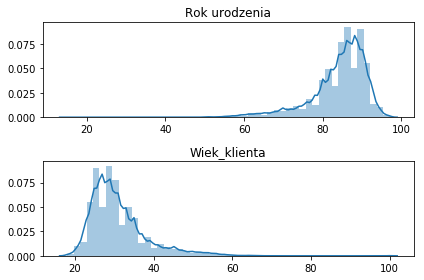

In [7]:
# Z kolumny DOB wyciągamy informację dotyczącu roku urodzenia naszego klienta, wartość może przydać się do modelowania
# sprawdzamy czy daty urodzenia są realne, z perspektywy roku 2015 - rok w którym jest wnioskowanie o pożyczkę
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

rok_urodzenia = [int(x.split('-')[2]) for x in  df['DOB']]
sns.distplot(rok_urodzenia, ax= ax1).set_title('Rok urodzenia')

# usuwam od roku 2015 rok urodzenia klienta
wiek = [2015 - (1900 + x) for x in rok_urodzenia]
sns.distplot(wiek, ax = ax2).set_title('Wiek_klienta')

print('max wiek: ', max(wiek), '\n','min wiek: ', min(wiek)) 
# po wyniku max i min widoczne, że dane prawdopodobnie zostały sztucznie spreparowane                                                     

df['wiek_klienta'] = wiek


fig.tight_layout() # funkcja robi ładne odstępy pięszy wykresami
plt.show()

#klienci w naszym pliku mają wiek maksymalnie 100 lat (urodzieni w roku 15) i minimalnie 18 lat (rok 97)

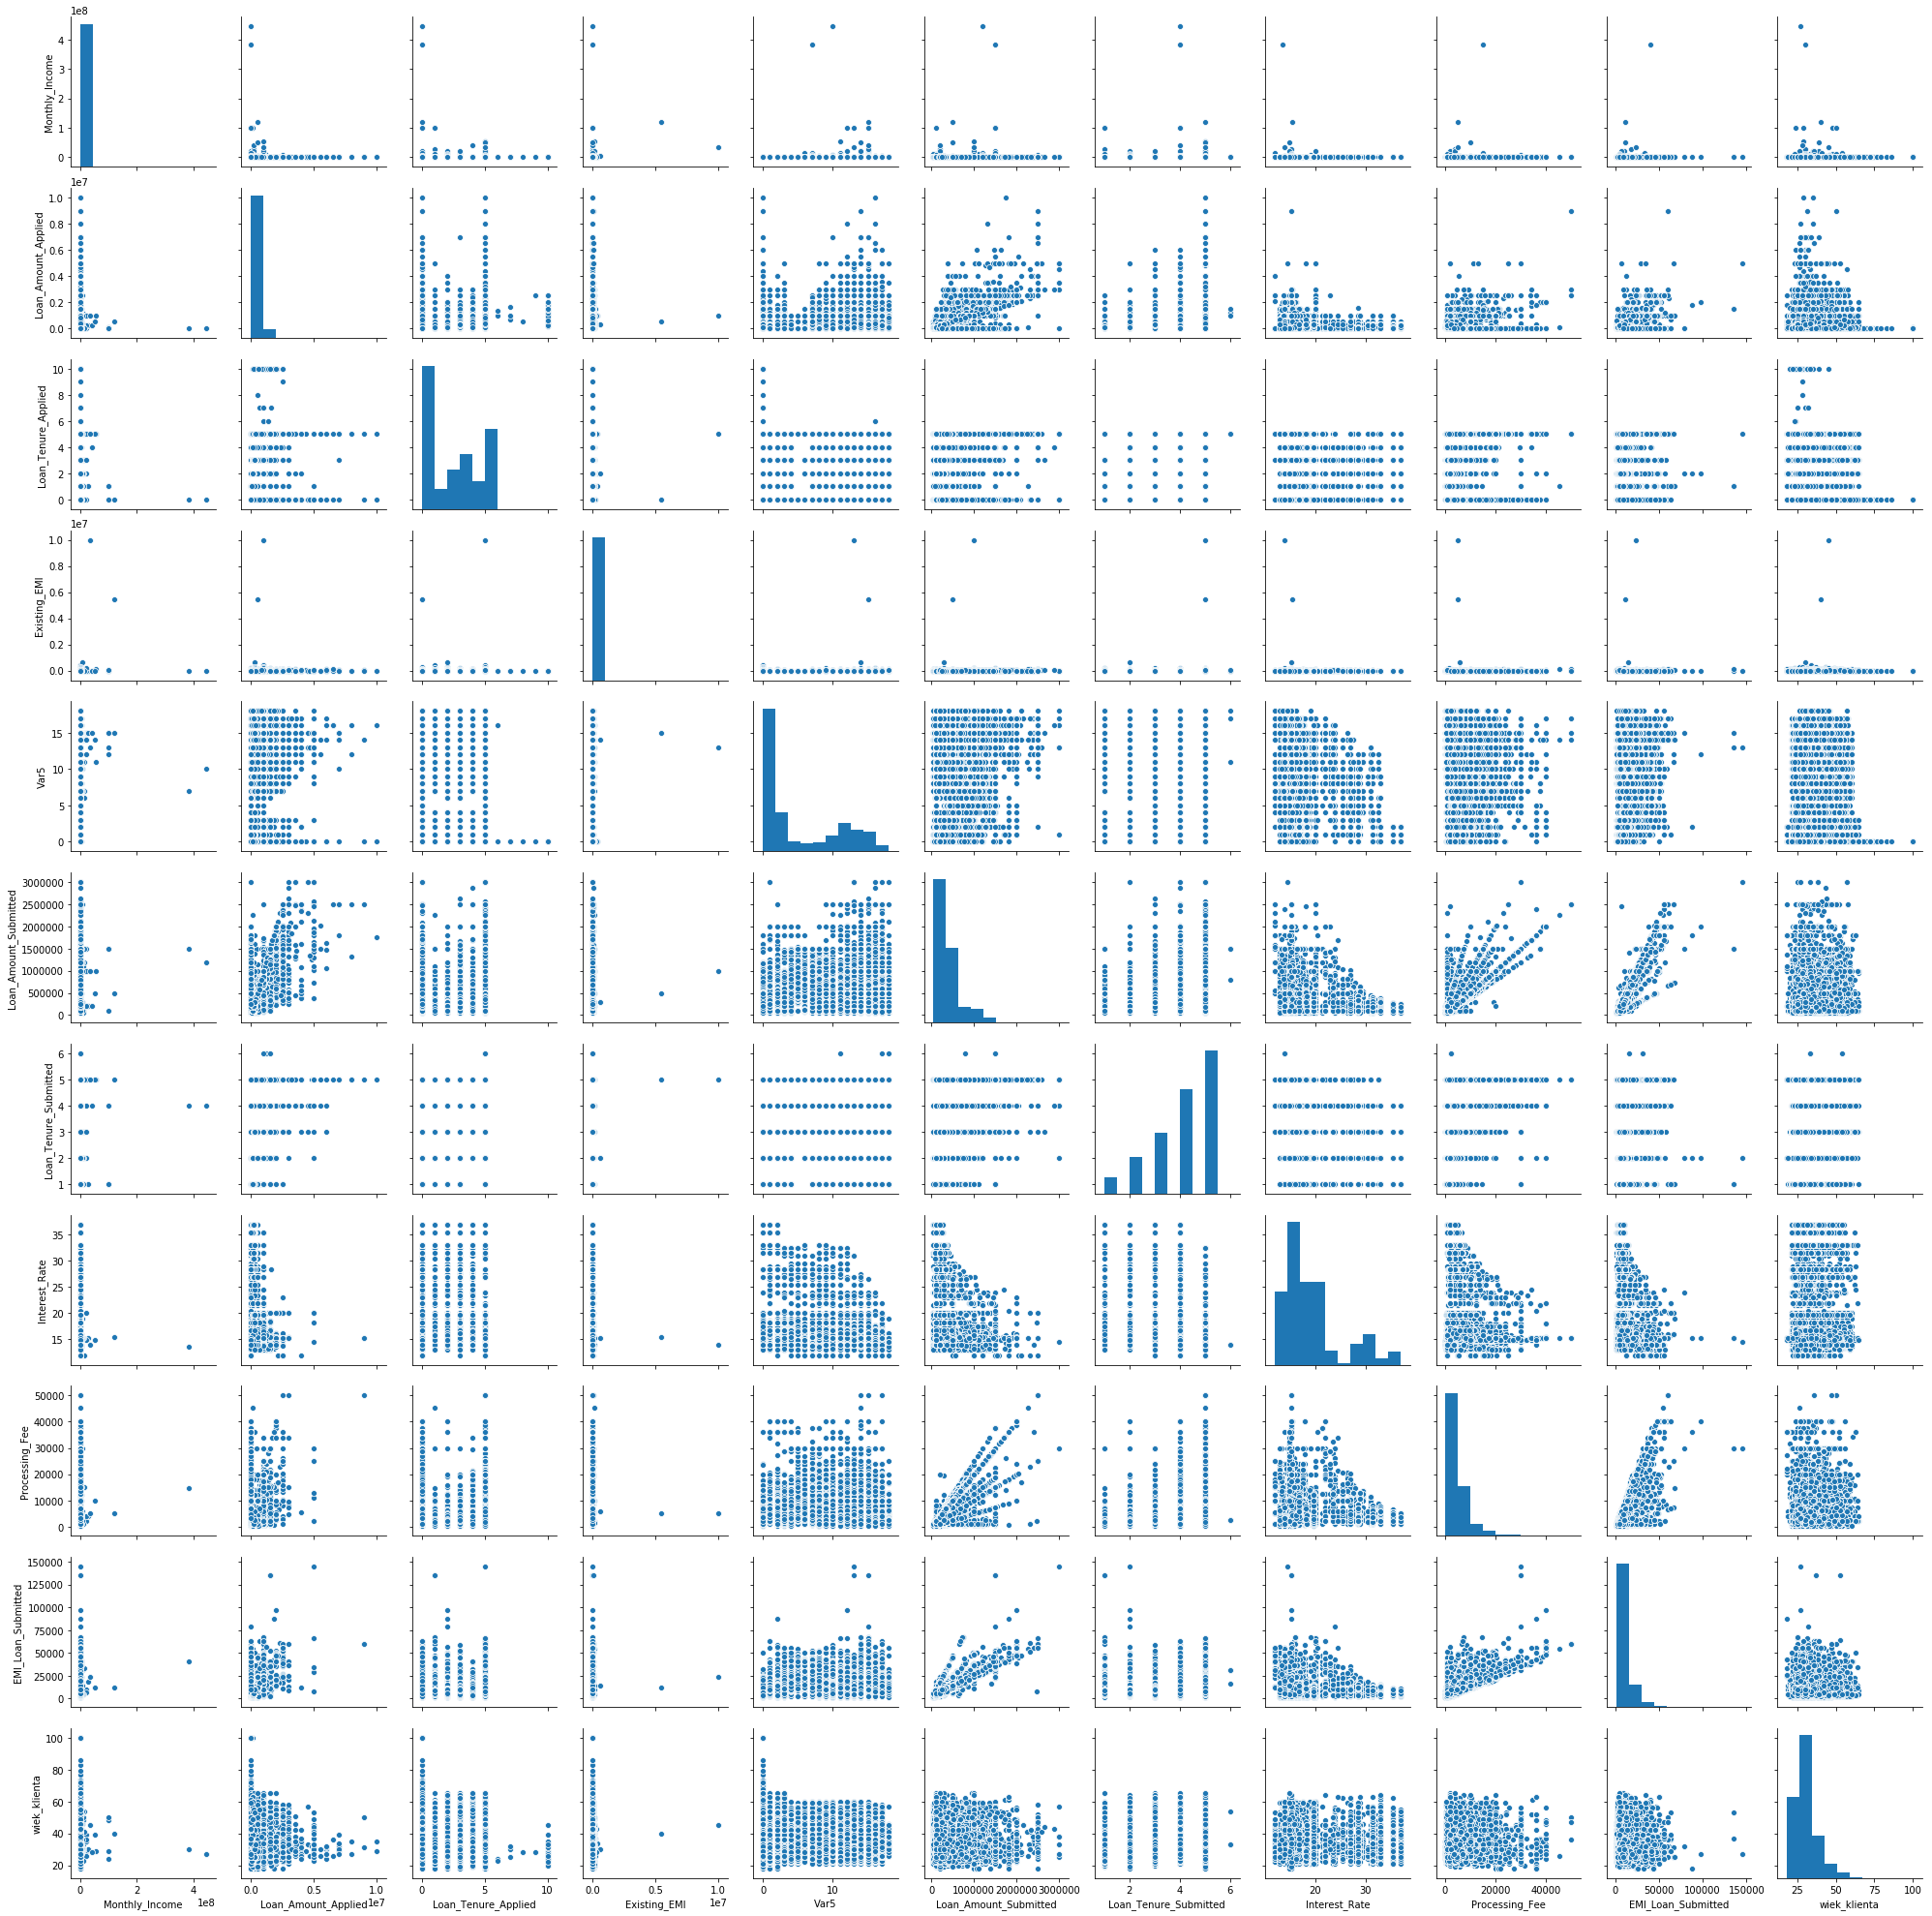

In [8]:
# z df wyciągamy wszytskie dane numeryczne ciągłe, żeby zobaczyć czy zachodzą międzu nimi korelacje liniowe
numeryczne = ['Monthly_Income','Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI', 'Var5', 'Loan_Amount_Submitted',\
             'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee', 'EMI_Loan_Submitted', 'wiek_klienta']

sns.pairplot(df[numeryczne])

In [9]:
# z powyższej macierzy wykresów można zaobserwować relacje pomiędzy kwotą wnioskowania a liczbą rat,
# widać również liniowe odcięcie poniżej którego wartości nie występują dla wykresu pokazującego
# relację ilości rat (EMI_loan_submitted) vs. opłatą manipulacyjną (processing_fee)
# obserwując dodaną kolumnę - wiek klienta można zaobserwować, relację z wnioskowaną kwotą pożyczki
# im starszy klient tym szerszy zakres wnioskowanych kwot o pożyczkę


In [10]:
# w kolejnym kroku zajmujemy się kolumnami numerycznymi zawierającymi NA
# zbudujemy funkcję do badania kolumn kategorycznych i numerycznych

# funkcja jako zmienne przyjmuje dataframe, wektor kolumn numerycznych/ kategorycznych oraz kategorię numerczyczne/ kategoryczne
# dla kolumn numerycznych zwraca: nazwę kolumny, inf. o ilości wartości NA, % wartości NA vs wszytstkie wartości,
# średnią, medianę oraz percentyle
# dla kolumn kategorycznych zwraca inf. o ilości wartości NA, % wartości NA vs wszytstkie wartości,
# oraz informację ile jest kategorii

def sprawdzanie_NA_value(df, kolumny, rodzaj):
    liczba_rekordów = len(df)
    lista = []
    
    #tworzymy pustego DataFrame do którego będziemy dodawać rekordy
    kolumny_na= ['nazwa' ,'ile_NA', 'proc_NA','percentyl_10','mediana', 'percentyl_90', 'średnia' ]
    if rodzaj == 'kategoryczne':
        kolumny_na= ['nazwa' ,'ile_NA', 'proc_NA','#unikalne_kategorie', 'unikalne_kategorie' ]
    df_na = pd.DataFrame(['' for i in range(len(kolumny_na))]).T        

    for kolumna in kolumny:
        df_ = df[kolumna]
        ile_na = df_[df_.isna()].size
        proc_na = str(np.round((ile_na/liczba_rekordów)*100,0))+'%'
        df_.dropna(inplace = True)
        if rodzaj == 'numeryczne':
            percentyl_10 = np.round(np.percentile(df_,10),0)
            mediana = np.round(np.percentile(df_,50),0)
            percentyl_90 = np.round(np.percentile(df_,90),0)
            srednia = np.round(np.mean(df_),0)
            for element in [kolumna ,ile_na, proc_na,percentyl_10, mediana, percentyl_90, srednia ]:
                lista.append(element)
        else:
            ile_unikalnych_kategorii = len(df_.unique())
            unikalne_kategorie = df_.unique()
            for element in [kolumna ,ile_na, proc_na, ile_unikalnych_kategorii, unikalne_kategorie ]:
                lista.append(element)            
        df_na_temp = pd.DataFrame(lista).T
        df_na = pd.concat([df_na,df_na_temp])
        lista = []    

    df_na.rename(columns = {i:j for i,j in zip(range(len(kolumny_na)), kolumny_na)}, inplace = True)    
    df_na = df_na.reset_index().drop('index', axis =1).drop(0)
    return df_na

In [11]:
df_na = sprawdzanie_NA_value(df, numeryczne, 'numeryczne')
df_na

,nazwa,ile_NA,proc_NA,percentyl_10,mediana,percentyl_90,średnia
1,Monthly_Income,0,0.0%,12000,25000,62000,58850
2,Loan_Amount_Applied,71,0.0%,0,100000,500000,230251
3,Loan_Tenure_Applied,71,0.0%,0,2,5,2
4,Existing_EMI,71,0.0%,0,0,10000,3696
5,Var5,0,0.0%,0,2,14,5
6,Loan_Amount_Submitted,34613,40.0%,100000,300000,800000,395011
7,Loan_Tenure_Submitted,34613,40.0%,2,4,5,4
8,Interest_Rate,59294,68.0%,14,18,32,19
9,Processing_Fee,59600,68.0%,1200,4000,10000,5131
10,EMI_Loan_Submitted,59294,68.0%,4102,9393,19151,11000


In [12]:
#podmieniam brakujące dane w kolumnach submitted na dane z kolumn aplied

df['Loan_Amount_Submitted'].fillna(df['Loan_Amount_Applied'], inplace=True)
df['Loan_Tenure_Submitted'].fillna(df['Loan_Tenure_Applied'], inplace=True)
df['EMI_Loan_Submitted'].fillna(df['Existing_EMI'], inplace=True)

# Pozostałe braki zastąpimy medianą

for nazwa, mediana in zip(df_na['nazwa'],df_na['mediana']):
     df.update(df[nazwa].fillna(mediana))


In [13]:
# sprawdzam, czy wszystkie NA zostały zastąpione medianą
sprawdzanie_NA_value(df, numeryczne,'numeryczne')

,nazwa,ile_NA,proc_NA,percentyl_10,mediana,percentyl_90,średnia
1,Monthly_Income,0,0.0%,12000,25000,62000,58850
2,Loan_Amount_Applied,0,0.0%,0,100000,500000,230144
3,Loan_Tenure_Applied,0,0.0%,0,2,5,2
4,Existing_EMI,0,0.0%,0,0,10000,3693
5,Var5,0,0.0%,0,2,14,5
6,Loan_Amount_Submitted,0,0.0%,140000,300000,560000,357219
7,Loan_Tenure_Submitted,0,0.0%,3,4,5,4
8,Interest_Rate,0,0.0%,16,18,20,18
9,Processing_Fee,0,0.0%,2500,4000,5400,4356
10,EMI_Loan_Submitted,0,0.0%,7271,9393,11781,9905


In [14]:
# za pomocą wcześniej napisanej funkcji sprawdzam teraz zmienne kategoryczne pod kątem ilości  NA, 
# usuwam ze zbioru kolumn kolumny, które analizowaliśmy wcześniej jako kolumny numeryczne, 
# usuwam również numer ID oraz daty
kategoryczne = df.drop(numeryczne, axis =1).keys()[:-1].drop(['DOB', 'Lead_Creation_Date','ID'])
kategoryczne

sprawdzanie_NA_value(df,kategoryczne,'kategoryczne')

,nazwa,ile_NA,proc_NA,#unikalne_kategorie,unikalne_kategorie
1,Gender,0,0.0%,2,"[Female, Male]"
2,City,1003,1.0%,697,"[Delhi, Mumbai, Panchkula, Saharsa, Bengaluru,..."
3,Employer_Name,71,0.0%,43567,"[CYBOSOL, TATA CONSULTANCY SERVICES LTD (TCS),..."
4,Salary_Account,11764,14.0%,57,"[HDFC Bank, ICICI Bank, State Bank of India, H..."
5,Mobile_Verified,0,0.0%,2,"[N, Y]"
6,Var1,0,0.0%,19,"[HBXX, HBXA, HAXM, HAXB, HBXC, HBXD, HBXH, HAX..."
7,Filled_Form,0,0.0%,2,"[N, Y]"
8,Device_Type,0,0.0%,2,"[Web-browser, Mobile]"
9,Var2,0,0.0%,7,"[G, B, C, E, F, D, A]"
10,Source,0,0.0%,30,"[S122, S143, S134, S133, S159, S151, S137, S12..."


In [15]:
# W przypadku kolumn z kategoriami NA występują w kolumnach z miastem oraz z informacją dotyczącą 
# rachunku, na który przelewane jest wynagrodzeń, zobaczę, czy któraś z kategorii występuje częściej niż pozatełe

miasta = df['ID'].groupby(df['City']).agg('size' )
# miasta.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

miasta.groupby('City').apply(lambda x: np.round( 100 * x / miasta.sum(),2)).sort_values(ascending=False).head(10)

City
Delhi        14.56
Bengaluru    12.58
Mumbai       12.55
Hyderabad     8.45
Chennai       8.04
Pune          6.05
Kolkata       3.36
Ahmedabad     2.08
Jaipur        1.55
Gurgaon       1.41
Name: ID, dtype: float64

In [16]:
# Najwięcej pozycji jest z Delphi, dlatego zamienimy NA na miasto Delphi, nie powinno to bardzo wpłynąć w późniejszym czasie
# na model ponieważ mamy tylko 1% braków
df.update(df[['ID','City']].fillna('Delhi'))


In [17]:
# podobnie w przypadku rachunków bankowych, oglądamy top kategorie
miasta = df['ID'].groupby(df['Salary_Account']).agg('size' )
miasta = miasta.groupby('Salary_Account').apply(lambda x: \
                                                np.round( 100 * x / miasta.sum(),2)).sort_values(ascending=False).head(20)
miasta

Salary_Account
HDFC Bank                    23.51
ICICI Bank                   18.12
State Bank of India          15.74
Axis Bank                    11.67
Citibank                      3.16
Kotak Bank                    2.75
IDBI Bank                     2.06
Punjab National Bank          1.60
Bank of India                 1.55
Bank of Baroda                1.50
Canara Bank                   1.32
Standard Chartered Bank       1.32
Union Bank of India           1.26
Yes Bank                      1.04
ING Vysya                     0.90
Corporation bank              0.86
Indian Overseas Bank          0.81
State Bank of Hyderabad       0.79
Indian Bank                   0.74
Oriental Bank of Commerce     0.70
Name: ID, dtype: float64

In [18]:
# Widać tutaj dominującą kategorię HDFC BANK, jednak nie będziemy zamieniali wszystkich brakujących kategorii
# ponieważ mamy ponad 14% braków w tej kolumnie, zamiana kategorii spowodowałaby, że HDFC Bank zyskałby 38% udziału,
# gdzie w rzeczywistości wiemy o 23,5% udziale. 
# W tym przypadku spróbujemy dodać jedną sztuczną kategorię

# Najwięcej pozycji jest z Delhi, dlatego zamienimy NA na miasto Delphi
df.update(df[['ID','Salary_Account']].fillna('other'))
df.update(df[['ID','Employer_Name']].fillna('other'))

In [19]:
# sprawdzam jaki wpływ na uruchomienie kredytu ma posiadanie rachunku w popupalrnym Banku
df['account'] = [1 if x in ['HDFC Bank','ICICI Bank','State Bank of India','Axis Bank','Citibank', 'Kotak Bank']\
                 else 0 for x in df['Salary_Account'] ]

print('procent wniosków z udzieloną pożyczką dla klentów z rachunkiem w jednym z top 6 Banków: ',\
      str(np.round(((df[(df['Disbursed']==1)&(df['account']==1)].size/df[(df['account'])==1].size)*100),1))+'%')
print('procent wniosków z udzieloną pożyczką dla klentów z rachunkiem w mniej popularnym Banku: '\
      ,str(np.round(((df[(df['Disbursed']==1)&(df['account']==0)].size/df[(df['account'])==0].size)*100),1))+'%')
print('procent wniosków z udzieloną pożyczką z brakmiem informacji o Banku, w którym jest rachunek: '\
      ,str(np.round(((df[(df['Disbursed']==1)&(df['Salary_Account']=='other')].size/df[df['Salary_Account']=='other'].size)*100),1))+'%')

procent wniosków z udzieloną pożyczką dla klentów z rachunkiem w jednym z top 6 Banków:  1.9%
procent wniosków z udzieloną pożyczką dla klentów z rachunkiem w mniej popularnym Banku:  0.7%
procent wniosków z udzieloną pożyczką z brakmiem informacji o Banku, w którym jest rachunek:  0.2%


In [20]:
# Z powyższych obliczeń wynika, można wywnioskować, że posiadania konta w popularnym Banku
# pozytywnie wpływa na uruchomienie pożyczki

In [21]:
# sprawdzimy za pomocą naszej funkcji, czy wszystkie braki zostały uzupełnione
spr_kat = sprawdzanie_NA_value(df,kategoryczne,'kategoryczne')
spr_kat

,nazwa,ile_NA,proc_NA,#unikalne_kategorie,unikalne_kategorie
1,Gender,0,0.0%,2,"[Female, Male]"
2,City,0,0.0%,697,"[Delhi, Mumbai, Panchkula, Saharsa, Bengaluru,..."
3,Employer_Name,0,0.0%,43567,"[CYBOSOL, TATA CONSULTANCY SERVICES LTD (TCS),..."
4,Salary_Account,0,0.0%,58,"[HDFC Bank, ICICI Bank, State Bank of India, H..."
5,Mobile_Verified,0,0.0%,2,"[N, Y]"
6,Var1,0,0.0%,19,"[HBXX, HBXA, HAXM, HAXB, HBXC, HBXD, HBXH, HAX..."
7,Filled_Form,0,0.0%,2,"[N, Y]"
8,Device_Type,0,0.0%,2,"[Web-browser, Mobile]"
9,Var2,0,0.0%,7,"[G, B, C, E, F, D, A]"
10,Source,0,0.0%,30,"[S122, S143, S134, S133, S159, S151, S137, S12..."


In [22]:
# Należy teraz zmienić wszystkie dane kategoryczne na numeryczne, żeby móc przejśc do modelowania,
# kolumna Var4 jako kategorie ma podane liczby, dlatego ją pominiemy w pętli
for element in spr_kat['nazwa'][:-1]:
    liczbowe = df[element].astype('category').cat.codes
    df[element].update(liczbowe)

In [23]:
# Sprawdzimy, czy pętla zadziałała poprawnie i pozbyliśmy się kategorii w formacie string
sprawdzanie_NA_value(df,kategoryczne,'kategoryczne')

,nazwa,ile_NA,proc_NA,#unikalne_kategorie,unikalne_kategorie
1,Gender,0,0.0%,2,"[0, 1]"
2,City,0,0.0%,697,"[172, 446, 497, 568, 87, 604, 363, 625, 523, 1..."
3,Employer_Name,0,0.0%,43567,"[8691, 38690, 1833, 5698, 13513, 7977, 6877, 1..."
4,Salary_Account,0,0.0%,58,"[20, 22, 44, 21, 56, 57, 34, 27, 7, 3, 11, 41,..."
5,Mobile_Verified,0,0.0%,2,"[0, 1]"
6,Var1,0,0.0%,19,"[13, 8, 5, 2, 10, 11, 12, 1, 9, 6, 14, 18, 0, ..."
7,Filled_Form,0,0.0%,2,"[0, 1]"
8,Device_Type,0,0.0%,2,"[1, 0]"
9,Var2,0,0.0%,7,"[6, 1, 2, 4, 5, 3, 0]"
10,Source,0,0.0%,30,"[0, 16, 8, 7, 26, 19, 11, 4, 17, 1, 23, 20, 2,..."


## Modelowanie

In [24]:
from sklearn.pipeline import Pipeline
import pprint
from sklearn.model_selection import  GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler,  StandardScaler
from sklearn import svm, datasets


In [25]:

# najpierw sprawdzam czy % wniosków dla klientów, którzy otrzymali pożyczkę jest znaczący - gdyby nie był model
# mógłby dawać wysoki wynik z kiepsą siłą predykcji
print('procent wniosków z udzieloną pożyczką: ',str(np.round(((df[df['Disbursed']==1].size/df.size)*100),1))+'%')

procent wniosków z udzieloną pożyczką:  1.5%


In [26]:
# Nasz procent wniosków z pożyczką jest znacząco mały
# Sprawdźmy mimo to jakie prawdopodobieństwo będzie miał model

In [27]:
# Rozpocznijmy od przygotowania zbioru X i y
# usuwamy niepotrzebne dane takie ID, daty oraz kolumny z dopisem applied



X = df[['Monthly_Income', 'Var5', 'Loan_Amount_Submitted', 'Employer_Name',
       'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee',
       'EMI_Loan_Submitted', 'Var4', 'wiek_klienta', 'Gender',
       'Filled_Form', 'Mobile_Verified', 'Device_Type',
       'City', 'Salary_Account', 'Source', 'Var1', 'Var2']]


y = df['Disbursed']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

names = np.array(["Naiwny Bayes", "Drzewo decyzyjne", "Regresja logistyczna", "SVM",
                     "BaggingClassifier_tree", "BaggingClassifier_bayes",'BaggingClassifier_Logistic_Regression',\
                      "RandomForest"])



def modelujemy(X_train, X_test, y_train, y_test):




    models = [[("model", MultinomialNB())],
             [("model", DecisionTreeClassifier())],
             [("scaler", MaxAbsScaler()), ("model", LogisticRegression())],
             [("scaler", MaxAbsScaler()),("model", SVC())],
             [("model", BaggingClassifier(base_estimator=DecisionTreeClassifier()))],
             [("model", BaggingClassifier(base_estimator=MultinomialNB()))],
             [("model", BaggingClassifier(base_estimator=LogisticRegression()))],
             [("model", RandomForestClassifier())],
             ]



    param_grids = [{"model__alpha": [0.1, 1, 10], "model__fit_prior": [False, True]},
                   {"model__criterion": ["gini", "entropy"], "model__min_samples_split": [ 2, 10, 100],\
                    "model__max_depth": [None, 2, 10, 100]}, 
                   {"model__penalty": ["l1", "l2"], "model__C": [0.1, 1, 10, 100]},
                  [{"model__kernel": ["rbf"], "model__gamma": [0.1, 1]},
                  {"model__kernel": ["poly"], "model__degree": [2, 3, 
                                                               ]}],
                   {"model__n_estimators" : [2, 5, 50, 100], "model__max_features": [0.001,0.2, 0.5]},
                   {"model__n_estimators" : [2, 5, 50, 100], "model__max_features": [0.001,0.2, 0.5]},
                   {"model__n_estimators" : [2, 5, 50, 100], "model__max_features": [0.001,0.2, 1]},
                   {"model__n_estimators" : [2, 5, 50, 100]}
                  ]

    uses = np.array([True, True, True, False, True, True, False, True])



    if len(names) != len(models) or len(models) != len(param_grids) or len(param_grids) != len(uses):
        print(f"len(names): {len(names)}")
        print(f"len(models): {len(models)}")
        print(f"len(param_grids): {len(param_grids)}")
        print(f"len(uses): {len(uses)}")
        raise ValueError("Listy nie mają tej samej długości!")

    best_models = []

    for use, name, pipe, params in zip(uses, names, models, param_grids):
        if not use:
            continue

        print(f"Tunuje model: {name}")
    #    pipeline = Pipeline(vectorizer+pipe)
        pipeline = Pipeline(pipe)
        gs = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=3)
        gs.fit(X_train, y_train)
        for mean, std, param, fit_time, score_time in zip(gs.cv_results_["mean_test_score"],
                                    gs.cv_results_["std_test_score"],
                                    gs.cv_results_["params"],
                                    gs.cv_results_["mean_fit_time"],
                                    gs.cv_results_["mean_score_time"]):

            print(f"{param}:\n mean: {np.round(mean, 4)}, std: {np.round(std,4)},\n fit_time: {np.round(fit_time, 4)}, score_time: {np.round(score_time,4)}\n")
        best_models.append(gs.best_estimator_)
    best_models = np.array(best_models)

    return best_models
    
najlepsze_modele = modelujemy(X_train, X_test, y_train, y_test)
 

Tunuje model: Naiwny Bayes
{'model__alpha': 0.1, 'model__fit_prior': False}:
 mean: 0.4328, std: 0.1255,
 fit_time: 0.1633, score_time: 0.0621

{'model__alpha': 0.1, 'model__fit_prior': True}:
 mean: 0.4331, std: 0.1256,
 fit_time: 0.1684, score_time: 0.0692

{'model__alpha': 1, 'model__fit_prior': False}:
 mean: 0.4328, std: 0.1255,
 fit_time: 0.1729, score_time: 0.0662

{'model__alpha': 1, 'model__fit_prior': True}:
 mean: 0.4331, std: 0.1256,
 fit_time: 0.1681, score_time: 0.0649

{'model__alpha': 10, 'model__fit_prior': False}:
 mean: 0.4328, std: 0.1255,
 fit_time: 0.1797, score_time: 0.0777

{'model__alpha': 10, 'model__fit_prior': True}:
 mean: 0.4331, std: 0.1256,
 fit_time: 0.1487, score_time: 0.059

Tunuje model: Drzewo decyzyjne
{'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_split': 2}:
 mean: 0.9675, std: 0.001,
 fit_time: 0.7415, score_time: 0.0618

{'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_split': 10}:
 mean: 0.

{'model__n_estimators': 2}:
 mean: 0.9842, std: 0.0002,
 fit_time: 0.3559, score_time: 0.065

{'model__n_estimators': 5}:
 mean: 0.9844, std: 0.0002,
 fit_time: 0.6855, score_time: 0.0964

{'model__n_estimators': 50}:
 mean: 0.9853, std: 0.0001,
 fit_time: 5.3231, score_time: 0.4084

{'model__n_estimators': 100}:
 mean: 0.9853, std: 0.0001,
 fit_time: 10.4901, score_time: 0.7602



In [29]:
def tabelka(best_models, metoda):
    df_tabela = pd.DataFrame()
    uses = np.array([True, True, True, False, True, True, False, True])
    for name, best_model in zip(names[uses], best_models):
        lista = []
        accurancy = accuracy_score(best_model.predict(X_test), y_test)
        roc_accurancy = roc_auc_score(best_model.predict(X_test), y_test)
        lista.append(name)
        lista.append(accurancy)
        lista.append(roc_accurancy)
        lista.append(best_model[0])
        lista.append(metoda)
        df_temporary = pd.DataFrame(lista)
        df_tabela = pd.concat([df_tabela, df_temporary], axis =1)
    df_tabela = df_tabela.T
    df_tabela.rename(columns = {0:'nazwa',1:'Accurancy score',2:'ROC accurancy',3:'details', 4:'zbiór'}, inplace = True)    
    return df_tabela
niezbalansowana = tabelka(najlepsze_modele,'niezbalansowany zbiór')    
niezbalansowana

NameError: name 'roc_auc_score' is not defined

In [ ]:
# Niestety błąd modelu jest niedpouszczalny, ponieważ 1,5% wniosków dochodzi do uruchomienia. W najgorszym przypadku każdy
# z uruchomionych wniosków może być podany błędnie nadal zachowując 98,5% prawdopodobieństwo modelu

## undersampling & oversampling methods
Spróbujemy wykorzystać metody undersampling (pomniejszające zbiór z przeważającą kategorią, w naszym przypadku zbiór wszytskich niesprzedanych kredytów, minus - tracimy sporo informacji)
oraz oversampling (powiększenie zbioru z kategorią o mniejszej liczebności, w naszym przypadku oznaczać to będzie powiększanie zbioru uruchomionych kredytów, minus - uczymy model na zdublowanych informacjach albo wyznaczonych za pomocą nienadzorowanych
medot ML).
Metody wykorzystujemy wyłącznie na zbiorze treningowym.

In [ ]:
#undersampling, z wykorzystaniem np.random
X = df[['Monthly_Income', 'Var5', 'Loan_Amount_Submitted',
       'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee',
       'EMI_Loan_Submitted', 'Var4', 'wiek_klienta', 'Gender',
       'Filled_Form', 'Mobile_Verified', 'Device_Type',
       'City', 'Employer_Name', 'Salary_Account',
       'Source', 'Var1', 'Var2', 'Disbursed']]
y = df['Disbursed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

uruchomione = len(X_train[X_train['Disbursed'] == 1])
nieuruchomione =  X_train[X_train['Disbursed']==0].index
random_index = np.random.choice(nieuruchomione,uruchomione, replace=False)
uruchomione_index = df[df['Disbursed'] == 1].index
under_sample_index = np.concatenate([uruchomione_index,random_index])
under_sample = X_train.loc[under_sample_index] # nasz zbiór X
under_sample.dropna(axis = 0, inplace = True)
y_train = under_sample['Disbursed']
X_train = under_sample
print(X_train['Disbursed'].value_counts())
X_train = X_train.drop('Disbursed', axis =1)
X_test = X_test.drop('Disbursed', axis =1)

In [ ]:
najlepsze_modele = modelujemy(X_train, X_test, y_train, y_test)
undersampling_random = tabelka(najlepsze_modele,'random')    
undersampling_random

In [ ]:
# Metoda bardzo poprawiła wyniki, jednak poprzez zastosowanie tej metody straciliśmy bardzo dużą część informacji o kredytach
# które nie zostały zrealizowane poprawnie

In [ ]:
# oversampling, z opcją zwielokrotnienia wniosków z uruchomieniem
X = df[['Monthly_Income', 'Var5', 'Loan_Amount_Submitted',
       'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee',
       'EMI_Loan_Submitted', 'Var4', 'wiek_klienta', 'Gender',
       'Filled_Form', 'Mobile_Verified', 'Device_Type',
       'City', 'Employer_Name', 'Salary_Account',
       'Source', 'Var1', 'Var2', 'Disbursed']]
y = df['Disbursed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

uruchomione = len(X_train[X_train['Disbursed'] == 1])
nieuruchomione =  len(X_train[X_train['Disbursed']==0])
proporcja =nieuruchomione /  uruchomione 

X_train =X_train.append([X_train[X_train['Disbursed'] == 1]]*int(np.round(proporcja,0)),ignore_index=True)
y_train = X_train['Disbursed']

print(X_train['Disbursed'].value_counts())
X_train = X_train.drop('Disbursed', axis =1)
X_test = X_test.drop('Disbursed', axis =1)


In [ ]:
najlepsze_modele = modelujemy(X_train, X_test, y_train, y_test)
oversampling_random = tabelka(najlepsze_modele,'oversampling_random')    
oversampling_random

## undersampling, oversampling z biblioteką imblearn

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
X = df[['Monthly_Income', 'Var5', 'Loan_Amount_Submitted',
       'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee',
       'EMI_Loan_Submitted', 'Var4', 'wiek_klienta', 'Gender',
       'Filled_Form', 'Mobile_Verified', 'Device_Type',
       'City', 'Employer_Name', 'Salary_Account',
       'Source', 'Var1', 'Var2']]
y = df['Disbursed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

ros = RandomUnderSampler(random_state=0)
X_train, y_train = ros.fit_sample(X_train, y_train)
print(pd.DataFrame(y_train)[0].value_counts())


In [ ]:
najlepsze_modele = modelujemy(X_train, X_test, y_train, y_test)
RandomUnderSampler_imblearn = tabelka(najlepsze_modele,'RandomUnderSampler_imblearn')    
RandomUnderSampler_imblearn

In [ ]:
X = df[['Monthly_Income', 'Var5', 'Loan_Amount_Submitted',
       'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee',
       'EMI_Loan_Submitted', 'Var4', 'wiek_klienta', 'Gender',
       'Filled_Form', 'Mobile_Verified', 'Device_Type',
       'City', 'Employer_Name', 'Salary_Account',
       'Source', 'Var1', 'Var2']]
y = df['Disbursed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_sample(X_train, y_train)
print(pd.DataFrame(y_train)[0].value_counts())


In [ ]:
najlepsze_modele = modelujemy(X_train, X_test, y_train, y_test)
RandomOverSampler_imblearn = tabelka(najlepsze_modele,'RandomOverSampler_imblearn')    
RandomOverSampler_imblearn

## imblearn: SMOTE oversampling

SMOTE = Synthetic Minority Oversampling Technique

In [ ]:
from imblearn.over_sampling import SMOTE

X = df[['Monthly_Income', 'Var5', 'Loan_Amount_Submitted',
       'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee',
       'EMI_Loan_Submitted', 'Var4', 'wiek_klienta', 'Gender',
       'Filled_Form', 'Mobile_Verified', 'Device_Type',
       'City', 'Employer_Name', 'Salary_Account',
       'Source', 'Var1', 'Var2']]
y = df['Disbursed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

print(pd.DataFrame(y_train)[0].value_counts())


In [ ]:
najlepsze_modele = modelujemy(X_train, X_test, y_train, y_test)
SMOTE_imblearn = tabelka(najlepsze_modele,'SMOTE_imblearn')    
SMOTE_imblearn

## imblearn: ADASYN  oversampling
Adaptive Synthetic 

In [ ]:
from imblearn.over_sampling import ADASYN

X = df[['Monthly_Income', 'Var5', 'Loan_Amount_Submitted',
       'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee',
       'EMI_Loan_Submitted', 'Var4', 'wiek_klienta', 'Gender',
       'Filled_Form', 'Mobile_Verified', 'Device_Type',
       'City', 'Employer_Name', 'Salary_Account',
       'Source', 'Var1', 'Var2']]
y = df['Disbursed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

sm = ADASYN(random_state=12, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

print(pd.DataFrame(y_train)[0].value_counts())


In [ ]:
najlepsze_modele = modelujemy(X_train, X_test, y_train, y_test)
ADASYN_imblearn = tabelka(najlepsze_modele,'ADASYN_imblearn')    
ADASYN_imblearn

In [ ]:
tabelka = pd.concat([niezbalansowana,undersampling_random,oversampling_random,RandomUnderSampler_imblearn,\
RandomOverSampler_imblearn,SMOTE_imblearn, ADASYN_imblearn])

In [ ]:
tabelka